# 05-pytorch

Using GPU [FFN]

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download = True, transform = ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


image.shape: torch.Size([1, 28, 28])
Label: 5


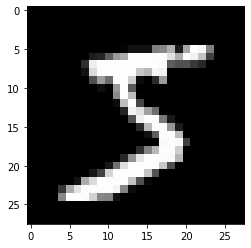

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size=128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Everything in here is as same as previous notebooks , but lets explore `num_workers` and `pin_memory` 

* Setting the argument num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes.

* For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

images.shape: torch.Size([128, 1, 28, 28])
tensor([4, 0, 7, 0, 3, 8, 5, 4, 0, 7, 9, 7, 8, 8, 3, 0, 5, 9, 6, 5, 2, 5, 8, 9,
        9, 5, 5, 3, 0, 5, 4, 9, 7, 2, 5, 3, 0, 3, 3, 4, 0, 9, 3, 3, 3, 4, 8, 6,
        7, 5, 7, 8, 7, 9, 1, 7, 6, 6, 3, 2, 7, 7, 7, 1, 6, 7, 1, 4, 6, 2, 5, 8,
        8, 9, 9, 8, 5, 0, 3, 5, 7, 0, 4, 2, 6, 5, 5, 9, 5, 9, 8, 2, 5, 1, 7, 2,
        0, 2, 6, 2, 3, 7, 0, 9, 0, 7, 7, 2, 8, 6, 2, 1, 7, 4, 8, 4, 9, 7, 3, 0,
        9, 2, 4, 1, 4, 1, 9, 9])


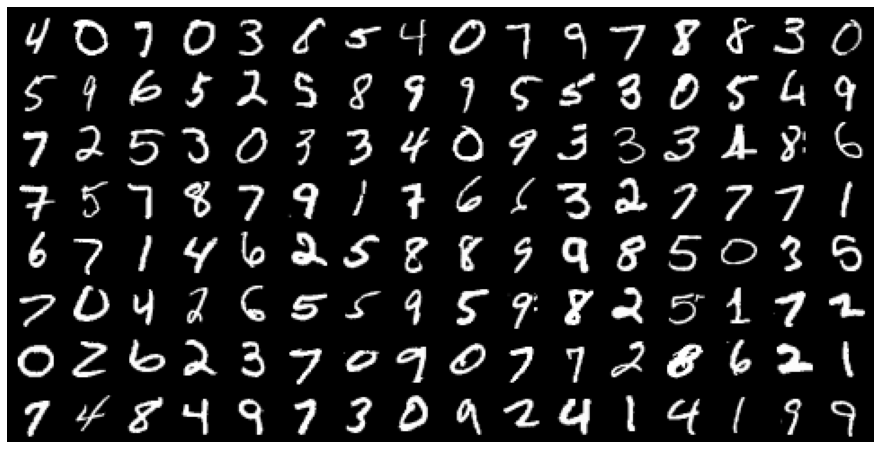

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    print(_)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Function and Non-Linearity

We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an  _activation function_ between two layers
Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationship between input and output

First , let's create a batch of input tensors. We'll flatten 1x28x28 images into vector of size 784, so they can be passed into an nn.Linear object

In [8]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape torch.Size([128, 784])


The image vector of the size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer 1 and adding the bias. We can verify this.

In [9]:
input_size = inputs.shape[-1] # automatically detects 784
hidden_size = 32

In [10]:
layer1 = nn.Linear(input_size, hidden_size)

In [11]:
inputs.shape

torch.Size([128, 784])

In [12]:
input_size

784

In [13]:
layer1_outputs = layer1(inputs)
layer1_outputs.shape

torch.Size([128, 32])

The layer1 and layer23 has only linear relationships between input and output
Next, we'll use the Linear Unit(ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x). i.e. it simply replaces negetive values in a given tensor with the value 0. ReLU  is a non linear function. We can apply F.relu method to apply ReLU to the elements of a tensor. Think relu as a trigger in neuron.

In [14]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [15]:
relu_outputs = F.relu(layer1_outputs)


Now that we've applied a non-linear activation function, relu_outputs and inputs do not have a linear relationship.

Next create an output layer to conver vectors of length hidden_size in relu_outputs into vectors of length 10, which is the desired output of our model[since there are 10 target labels].

In [16]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [17]:
layer2_outputs = layer2(relu_outputs)
layer2_outputs.shape

torch.Size([128, 10])

In [18]:
inputs.shape

torch.Size([128, 784])

In [19]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3172, grad_fn=<NllLossBackward>)

by using cross entropy we can adjust weights of layer1 and layer2

## Model

In [51]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [52]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [53]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [54]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Lets try the model with first batch of data

In [55]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break
print(outputs[0:1].data)

Loss: 2.326331377029419
tensor([[ 0.0304,  0.0821, -0.1201, -0.0814,  0.2114,  0.2478, -0.0845,  0.1256,
          0.0331, -0.2315]])


## Using GPU

In [56]:
torch.cuda.is_available()

False

In [57]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [58]:
device = get_default_device()
device

device(type='cpu')

In [59]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Python isinstance() Function
# The isinstance() function returns True if the 
# specified object is of the specified type, otherwise False .
# If the type parameter is a tuple, this function will return True if
# the object is one of the types in the tuple.

In [60]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch data loader. All we need is an __iter__ method to retrieve batches of data and an __len__ method to get the number of batches

In [61]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

The `yield` keyword in python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [62]:
def some_number():
    yield 10
    yield 20
    yield 30
    
for value in some_numbers():
    print(value)

10
20
30


We can now wrap  our data loader using DeviceDataLoader.

In [63]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a device property which includes the word cuda. Let's verify this by looking at a batch of data from valid_dl

In [64]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([2, 0, 8, 6, 1, 4, 3, 8, 5, 4, 2, 1, 2, 3, 6, 0, 3, 7, 3, 1, 1, 5, 4, 1,
        0, 3, 0, 6, 0, 3, 5, 2, 9, 2, 0, 4, 4, 5, 3, 2, 2, 1, 7, 3, 0, 7, 2, 2,
        9, 0, 4, 5, 6, 1, 4, 7, 6, 6, 5, 4, 3, 1, 1, 9, 8, 4, 3, 9, 0, 8, 7, 2,
        0, 6, 7, 1, 2, 4, 1, 1, 8, 8, 1, 9, 1, 0, 3, 8, 7, 2, 7, 0, 7, 1, 0, 2,
        1, 9, 1, 6, 1, 8, 5, 6, 1, 4, 6, 8, 8, 3, 7, 6, 5, 6, 3, 0, 8, 7, 7, 2,
        7, 0, 6, 7, 1, 9, 6, 5, 6, 4, 5, 9, 4, 9, 8, 2, 6, 0, 5, 1, 1, 0, 6, 7,
        3, 8, 3, 0, 5, 2, 3, 5, 3, 2, 5, 1, 7, 8, 3, 5, 9, 4, 7, 4, 4, 0, 1, 5,
        8, 1, 8, 6, 2, 1, 0, 7, 9, 7, 6, 0, 0, 0, 0, 2, 1, 3, 7, 2, 4, 1, 2, 8,
        3, 2, 9, 5, 0, 4, 5, 6, 1, 2, 2, 8, 3, 8, 3, 9, 8, 6, 4, 7, 4, 9, 1, 8,
        5, 1, 1, 3, 6, 3, 0, 1, 1, 2, 5, 4, 9, 3, 3, 9, 3, 2, 5, 6, 4, 4, 7, 6,
        4, 7, 8, 6, 7, 2, 4, 6, 3, 2, 1, 9, 6, 5, 0, 0])


## Training the Model

We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set. 

In [65]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epoch, lr, model, train_loader, val_loader, opt_function = torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        #Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero.grad()
            
        #validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [66]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)